# Monte Carlo Integration

In [1]:
import numpy as np
from scipy.stats import gamma
from scipy.special import loggamma
import scipy
import matplotlib.pyplot as plt

##### Example 3.1 and Figure 3.1

loggamma (lgamma in R) function returns the natural logarithm of the absolute value of gamma function (log gamma function) of the argument. The log gamma function of x is defined as:

$\Gamma(\lambda) = \ln \big | \int_{0}^{\infty} x^{\lambda-1} \exp (-x) \mathrm{d} x \big |$

In [2]:
lambda_values = np.linspace(0.01, 10, 100)

In [3]:
def gamma_fun(x, lambda_value):
    return x**(lambda_value-1)*np.exp(-x)
def integral_on_gamma(lambda_value):
    return scipy.integrate.quad(gamma_fun, 0, np.inf, args = lambda_value)[0]

In [4]:
gamma_integrals = np.vectorize(integral_on_gamma)(lambda_values)
scipy_loggamma = loggamma(lambda_values)

Text(0.5, 1.0, 'Integrate.quad function VS direct log-gamma calculation')

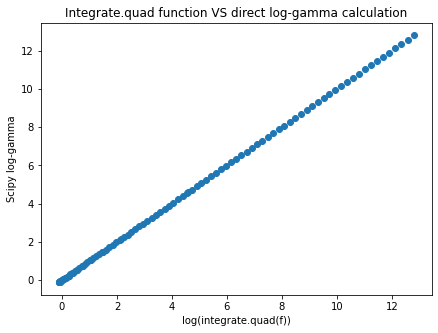

In [5]:
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(x = np.log(gamma_integrals), y = scipy_loggamma)
ax.set_xlabel('log(integrate.quad(f))')
ax.set_ylabel('Scipy log-gamma')
ax.set_title('Integrate.quad function VS direct log-gamma calculation')